In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
rng = np.random.default_rng()
import torch
from torch import nn
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def generate_gaussian_mixtures(*, num: int, rng: np.random.Generator) -> np.ndarray:
    angles = np.linspace(0, 2*np.pi, 8)[:-1]
    idxs = rng.choice(np.arange(len(angles)), size=num)
    X = np.hstack((
        1.2*np.cos(angles[idxs])[:, None],
        1.2*np.sin(angles[idxs])[:, None]
    ))
    X = X + rng.standard_normal(size=X.shape) * 0.12
    return X
gauss = generate_gaussian_mixtures(num=2000, rng=rng)

In [3]:
gauss.shape

(2000, 2)

In [4]:
# Assuming `X` is your NumPy array with the shape (1998, 2)
# For example:
# X = np.random.normal(size=(1998, 2))

# Convert numpy array to tensor and create a DataLoader
tensor_data = torch.tensor(gauss, dtype=torch.float32)
data_loader = DataLoader(TensorDataset(tensor_data), batch_size=64, shuffle=True)

# Device configuration
device = torch.device("mps")
device

device(type='mps')

In [5]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
epochs = 4000
epoch_losses = []
d_losses = []
g_losses = []
generator = Generator(50, 2).to(device)
discriminator = Discriminator(2).to(device)


g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)

In [7]:
for epoch in range(epochs):
    for real_data in data_loader:
        real_data = real_data[0].to(device)

        z = torch.randn(real_data.size(0), 50, device=device)
        fake_data = generator(z)

        d_real = discriminator(real_data)
        d_fake = discriminator(fake_data.detach())
        d_loss = -torch.mean(torch.log(d_real) + torch.log(1 - d_fake))

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        g_fake = discriminator(fake_data)
        g_loss = -torch.mean(torch.log(g_fake))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 100 == 0:
        epoch_losses.append(epoch + 1)
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        print(f'Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

Epoch 100/4000, D Loss: 1.0202, G Loss: 1.5313
Epoch 200/4000, D Loss: 0.9334, G Loss: 1.5188
Epoch 300/4000, D Loss: 1.1409, G Loss: 1.4506
Epoch 400/4000, D Loss: 1.3395, G Loss: 1.3343
Epoch 500/4000, D Loss: 1.0430, G Loss: 1.1151
Epoch 600/4000, D Loss: 1.2291, G Loss: 1.0936
Epoch 700/4000, D Loss: 1.2004, G Loss: 1.0272
Epoch 800/4000, D Loss: 1.0687, G Loss: 1.1732
Epoch 900/4000, D Loss: 1.0009, G Loss: 0.9693
Epoch 1000/4000, D Loss: 1.3210, G Loss: 1.0691
Epoch 1100/4000, D Loss: 1.3362, G Loss: 0.8453
Epoch 1200/4000, D Loss: 1.3530, G Loss: 0.9143
Epoch 1300/4000, D Loss: 1.1990, G Loss: 0.8558
Epoch 1400/4000, D Loss: 1.1555, G Loss: 1.1409
Epoch 1500/4000, D Loss: 1.3029, G Loss: 0.8619
Epoch 1600/4000, D Loss: 1.3245, G Loss: 0.9775
Epoch 1700/4000, D Loss: 1.2876, G Loss: 0.9382
Epoch 1800/4000, D Loss: 1.3455, G Loss: 0.8408
Epoch 1900/4000, D Loss: 1.2544, G Loss: 0.7349
Epoch 2000/4000, D Loss: 1.3040, G Loss: 0.8062
Epoch 2100/4000, D Loss: 1.3217, G Loss: 0.7032
E

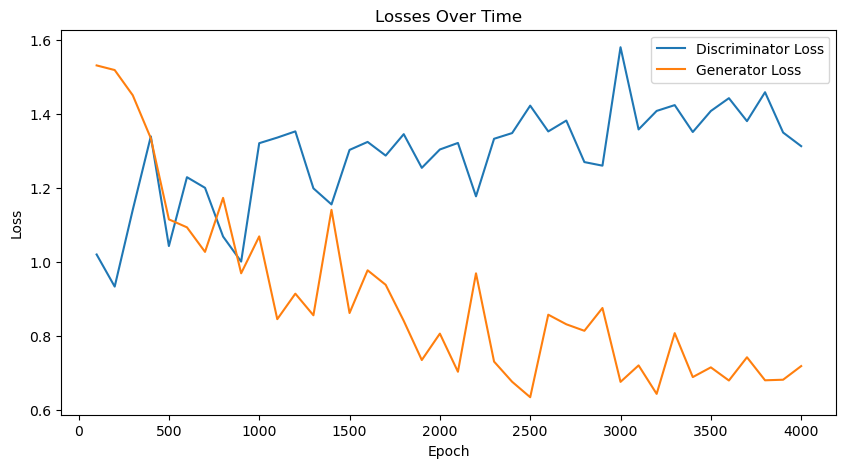

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, d_losses, label='Discriminator Loss')
plt.plot(epoch_losses, g_losses, label='Generator Loss')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

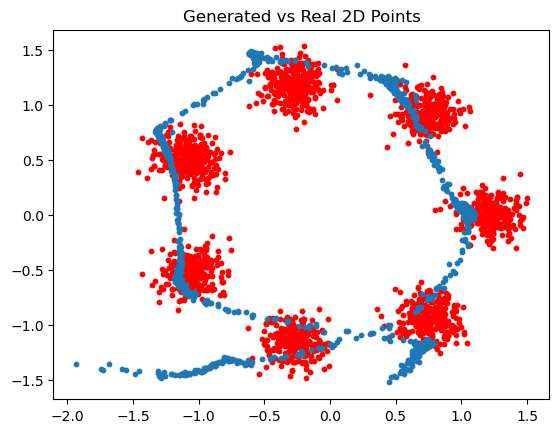

In [28]:
z = torch.randn(1000, 50, device=device)
generated_points = generator(z).detach().cpu().numpy()
plt.scatter(gauss[:, 0], gauss[:, 1], s=10, c='red')  

plt.scatter(generated_points[:, 0], generated_points[:, 1], s=10)
plt.title('Generated vs Real 2D Points')
plt.show()

In [32]:
torch.save(generator, 'GAN_gauss_gen.pth')
torch.save(Discriminator, 'GAN_gauss_disc.pth')

In [6]:
model = torch.load('GAN_gauss_gen.pth')
model.eval()

Generator(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [29]:

np.save("GAN_gauss.npy",generated_points)